In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons, load_breast_cancer

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

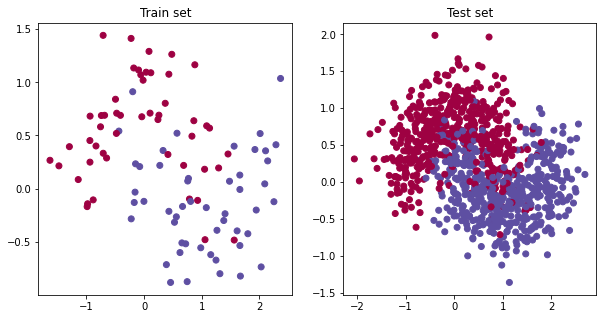

In [2]:
np.random.seed(16)
tr_x, tr_y = make_moons(100, noise=0.3)
ts_x, ts_y = make_moons(1000, noise=0.3)

xx, yy = np.meshgrid(np.arange(-2, 3, 0.05), np.arange(-1.5, 2.0, 0.05))
zz = np.concatenate([xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]], axis=1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(tr_x[:,0], tr_x[:,1], c=tr_y, cmap=plt.cm.Spectral)
axs[0].set_title('Train set')
axs[1].scatter(ts_x[:,0], ts_x[:,1], c=ts_y, cmap=plt.cm.Spectral)
axs[1].set_title('Test set')
plt.show()

# Stacking

Stacking is a general term for the (potentially complex) combination of classification outputs from multiple different models. There are lots of different ways to do this, but generally you want to do at least some optimization of the method of combination.

This generally means retaining a separate hold-out validation set to fit the stacking algorithm, though cross-validation may be used here at some risk of overfit.

General rules of thumb for stacking:

- Results are best when models are comparatively good. Stacking a 70% and 80% model will probably only give you an 80% model, but stacking a 79% and 80% model might give you an 83% model.
- Results are best when model predictions are as decorrelated from each-other as possible. This means that related methods (two different kinds of neural networks, for example) won't stack as well as methods that work via different principles from each-other.

Scikit-learn supplies a StackingClassifier that lets you combine a set of intermediate predictions via a sklearn estimator of your choice, and uses cross-validation to do the fitting of that estimator. So you can build fairly elaborate things with that interface.

But here lets consider the simplest kind of stacking by hand: weighted averaging.

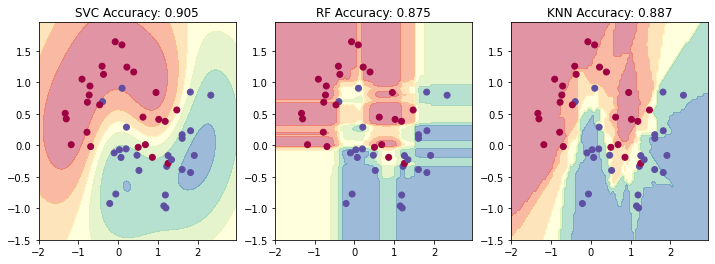

In [3]:
np.random.seed(12345)
tr_x, tr_y = make_moons(50, noise=0.3)
val_x, val_y = make_moons(50, noise=0.3) 
ts_x, ts_y = make_moons(1000, noise=0.3)

clf1 = SVC(C=1, gamma='scale', probability=True)
clf2 = RandomForestClassifier(n_estimators = 100)
clf3 = KNeighborsClassifier(n_neighbors=5)

clf1.fit(tr_x, tr_y)
clf2.fit(tr_x, tr_y)
clf3.fit(tr_x, tr_y)

plt.subplot(1,3,1)
plt.title("SVC Accuracy: %.6g" % clf1.score(ts_x, ts_y))
p = clf1.predict_proba(zz)

p = p.reshape((xx.shape[0], xx.shape[1], 2))
plt.contourf(xx,yy,p[:,:,1],alpha=0.5,cmap=plt.cm.Spectral)
plt.scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)

plt.subplot(1,3,2)
plt.title("RF Accuracy: %.6g" % clf2.score(ts_x, ts_y))
p = clf2.predict_proba(zz)

p = p.reshape((xx.shape[0], xx.shape[1], 2))
plt.contourf(xx,yy,p[:,:,1],alpha=0.5,cmap=plt.cm.Spectral)
plt.scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)

plt.subplot(1,3,3)
plt.title("KNN Accuracy: %.6g" % clf3.score(ts_x, ts_y))
p = clf3.predict_proba(zz)

p = p.reshape((xx.shape[0], xx.shape[1], 2))
plt.contourf(xx,yy,p[:,:,1],alpha=0.5,cmap=plt.cm.Spectral)
plt.scatter(tr_x[:,0], tr_x[:,1], c=tr_y,cmap=plt.cm.Spectral)
plt.gcf().set_size_inches((12,4))

plt.show()

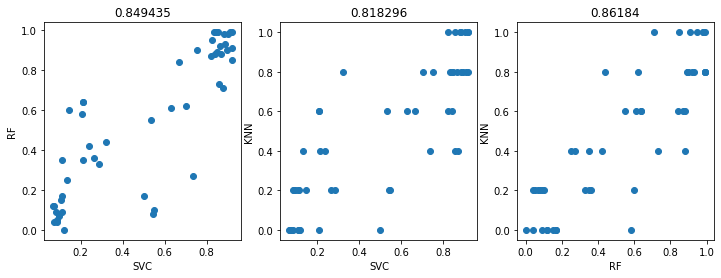

In [4]:
# We should examine the correlation between model predictions

p1 = clf1.predict_proba(val_x)
p2 = clf2.predict_proba(val_x)
p3 = clf3.predict_proba(val_x)

plt.subplot(1,3,1)
plt.scatter(p1[:,1], p2[:,1])
plt.xlabel("SVC")
plt.ylabel("RF")
plt.title("%.6g" % np.corrcoef(p1[:,1],p2[:,1])[0,1])

plt.subplot(1,3,2)
plt.scatter(p1[:,1], p3[:,1])
plt.xlabel("SVC")
plt.ylabel("KNN")
plt.title("%.6g" % np.corrcoef(p1[:,1],p3[:,1])[0,1])

plt.subplot(1,3,3)
plt.scatter(p2[:,1], p3[:,1])
plt.xlabel("RF")
plt.ylabel("KNN")
plt.title("%.6g" % np.corrcoef(p2[:,1],p3[:,1])[0,1])
plt.gcf().set_size_inches((12,4))
plt.show()

# Correlations are fairly similar - some hyperparameter changes can easily change which ones are most similar.

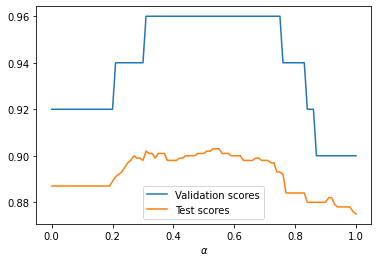

In [5]:
# Lets look at the accuracy of different mixtures of these models

alphas = np.arange(0,1.01,0.01)
val_scores = []
test_scores = []

for alpha in alphas:
    p = clf2.predict_proba(val_x)*alpha + clf3.predict_proba(val_x)*(1-alpha)
    val_scores.append(np.mean(np.argmax(p,axis=1)==val_y))

    p = clf2.predict_proba(ts_x)*alpha + clf3.predict_proba(ts_x)*(1-alpha)
    test_scores.append(np.mean(np.argmax(p,axis=1)==ts_y))
    
plt.plot(alphas, val_scores, label="Validation scores")
plt.plot(alphas, test_scores, label="Test scores")
plt.xlabel("$\\alpha$")
plt.legend()
plt.show()

In [6]:
# Or a three-way blend...

alphas = np.arange(0,1.01,0.01)

coords = []
val_scores = []
test_scores = []

# We don't really need to recompute these predictions every time...
vp1 = clf1.predict_proba(val_x)
vp2 = clf2.predict_proba(val_x)
vp3 = clf3.predict_proba(val_x)

tp1 = clf1.predict_proba(ts_x)
tp2 = clf2.predict_proba(ts_x)
tp3 = clf3.predict_proba(ts_x)

for alpha in alphas:
    betas = np.arange(0, alpha, 0.01)
    
    for beta in betas:
        p = vp1*alpha + vp2*beta + vp3*(1-alpha)*(1-alpha-beta)
        val_scores.append(np.mean(np.argmax(p,axis=1)==val_y))

        p = tp1*alpha + tp2*beta + tp3*(1-alpha)*(1-alpha-beta)
        test_scores.append(np.mean(np.argmax(p,axis=1)==ts_y))
        coords.append(np.array([alpha, beta, 1-alpha-beta]))
coords = np.array(coords)
val_scores = np.array(val_scores)
test_scores = np.array(test_scores)

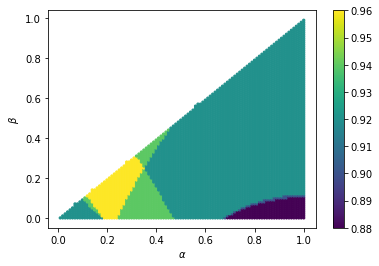

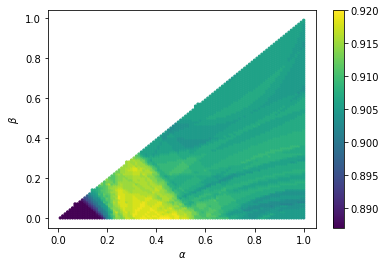

Best test accuracy: 0.92


In [7]:
plt.scatter(coords[:,0], coords[:,1], c=val_scores, s=5)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.colorbar()
plt.show()

plt.scatter(coords[:,0], coords[:,1], c=test_scores, s=5)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.colorbar()
plt.show()

print("Best test accuracy: %.6g" % np.max(test_scores))

In [8]:
# Another consideration is to use log probabilities rather than probabilities...
# It's going to be pretty similar though

alphas = np.arange(0,1.01,0.01)

coords = []
val_scores = []
test_scores = []

vp1 = np.log(1e-4 + clf1.predict_proba(val_x))
vp2 = np.log(1e-4 + clf2.predict_proba(val_x))
vp3 = np.log(1e-4 + clf3.predict_proba(val_x))

tp1 = np.log(1e-4 + clf1.predict_proba(ts_x))
tp2 = np.log(1e-4 + clf2.predict_proba(ts_x))
tp3 = np.log(1e-4 + clf3.predict_proba(ts_x))

for alpha in alphas:
    betas = np.arange(0, alpha, 0.01)
    
    for beta in betas:
        p = vp1*alpha + vp2*beta + vp3*(1-alpha)*(1-alpha-beta)
        val_scores.append(np.mean(np.argmax(p,axis=1)==val_y))

        p = tp1*alpha + tp2*beta + tp3*(1-alpha)*(1-alpha-beta)
        test_scores.append(np.mean(np.argmax(p,axis=1)==ts_y))
        coords.append(np.array([alpha, beta, 1-alpha-beta]))
coords = np.array(coords)
val_scores = np.array(val_scores)
test_scores = np.array(test_scores)

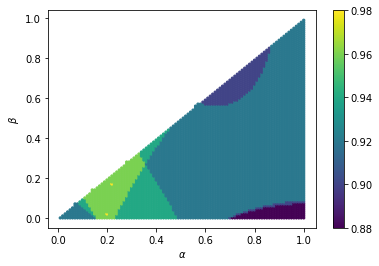

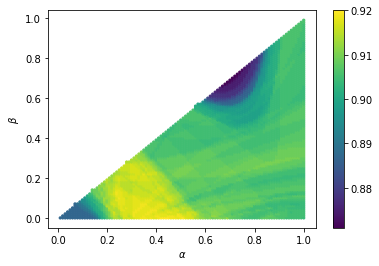

Best test accuracy: 0.92


In [9]:
plt.scatter(coords[:,0], coords[:,1], c=val_scores, s=5)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.colorbar()
plt.show()

plt.scatter(coords[:,0], coords[:,1], c=test_scores, s=5)
plt.xlabel("$\\alpha$")
plt.ylabel("$\\beta$")
plt.colorbar()
plt.show()

print("Best test accuracy: %.6g" % np.max(test_scores))

Notice that the best performance is actually achieved by a mixture of the two classifiers? This is the basic phenomenon behind stacking that we want to exploit. Of course we can do more complicated ways of both combining models, and figuring out the optimal way to combine them.

However, you might notice that the actual effect on test score is pretty small - we went from **90.5%** to **92.1%**, so **1.6%** improvement. That's why stacking tends to show up in competitions a lot, where rankings might depend on half a percent, but doesn't show up much in production. Of course, in higher dimensional data the effects can be more pronounced.